In [3]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import statsmodels.api as sm

#from skbio.stats.composition import clr
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.decomposition import PCA
from factor_analyzer import FactorAnalyzer

def color_big_red(val):
    color = 'red' if abs(val) >0.4 else 'black'
    return 'color: %s' % color

## Data 

In [4]:
data = pd.read_excel(r'C:\Users\boai-\Desktop\UnumAI\Colorado analysis\2020_CO_terms_cleaned.xlsx')

In [5]:
data.shape

(7795, 246)

In [6]:
data.head()

,Unnamed: 0,Term,Category,2019-02-15 00:00:00,2019-02-16 00:00:00,2019-02-17 00:00:00,2019-02-18 00:00:00,2019-02-19 00:00:00,2019-02-20 00:00:00,2019-02-21 00:00:00,...,2019-10-06 00:00:00,2019-10-07 00:00:00,2019-10-08 00:00:00,2019-10-09 00:00:00,2019-10-10 00:00:00,2019-10-11 00:00:00,2019-10-12 00:00:00,2019-10-13 00:00:00,2019-10-14 00:00:00,2019-10-15 00:00:00
0,0,% of people,Electability,NaN,0.000016,NaN,NaN,0.000010,NaN,NaN,...,NaN,NaN,0.000011,NaN,NaN,0.000012,NaN,NaN,NaN,NaN
1,1,1 diabetes,Healthcare,0.000014,0.000016,0.000019,NaN,NaN,NaN,0.000011,...,0.000036,0.000032,NaN,0.000010,0.000011,0.000021,0.000015,0.000018,0.000012,0.000010
2,2,1 president,Electability,0.000031,0.000035,0.000075,0.000071,0.000041,0.000077,0.000029,...,0.000046,0.000040,0.000035,0.000041,0.000047,0.000055,0.000030,0.000040,0.000041,0.000028
3,3,10 women,Social Equality,0.000010,NaN,0.000019,0.000012,NaN,0.000011,0.000011,...,NaN,0.000020,0.000011,NaN,0.000011,0.000021,NaN,NaN,0.000012,0.000018
4,4,100 homes,Economy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
data[['Category', 'Term']].groupby('Category').count()

,Term
Category,
Agriculture,52
Campaign Finance,45
Congress,275
Conspiracy,41
Corporate Regulation,51
Criminal Justice,323
Cybersecurity,23
Economy,1221
Education,285


In [8]:
# Setting up variables for each category.
# Not used but may be helpful
conspiracy = data[data['Category'].isin(['Conspiracy', 'Mueller/Russia'])]
corpreg_econ = data[data['Category'].isin(['Corporate Regulation','Economy'])]
crime = data[data['Category'].isin(['Criminal Justice', 'Public Safety', 'Guns'])]
Health= data[data['Category'].isin([ 'Healthcare'])]
education = data[data['Category'].isin(['Education'])]
electability = data[data['Category'].isin(['Electability'])]
environment = data[data['Category'].isin(['Environmental'])]
ethics = data[data['Category'].isin(['Ethics/Morals'])]
immigration = data[data['Category'].isin(['Immigration'])]
impeachment = data[data['Category'].isin(['Impeachment'])]
law_gov = data[data['Category'].isin(['Campaign Finance', 'Judiciary Branch', 'Generic Policy Queries', 'Voter Turnout', 'Election Security', 'Congress', 'Cybersecurity'])]
media = data[data['Category'].isin(['Media'])]
religion = data[data['Category'].isin(['Religion'])]
rephealth = data[data['Category'].isin(['Reproductive Health'])]
soceq = data[data['Category'].isin(['Social Equality'])]
taxes = data[data['Category'].isin(['Taxes/Spending'])]
trade_ag = data[data['Category'].isin(['Trade', 'Agriculture'])]
war = data[data['Category'].isin(['War'])]

In [9]:
data.head()

,Unnamed: 0,Term,Category,2019-02-15 00:00:00,2019-02-16 00:00:00,2019-02-17 00:00:00,2019-02-18 00:00:00,2019-02-19 00:00:00,2019-02-20 00:00:00,2019-02-21 00:00:00,...,2019-10-06 00:00:00,2019-10-07 00:00:00,2019-10-08 00:00:00,2019-10-09 00:00:00,2019-10-10 00:00:00,2019-10-11 00:00:00,2019-10-12 00:00:00,2019-10-13 00:00:00,2019-10-14 00:00:00,2019-10-15 00:00:00
0,0,% of people,Electability,NaN,0.000016,NaN,NaN,0.000010,NaN,NaN,...,NaN,NaN,0.000011,NaN,NaN,0.000012,NaN,NaN,NaN,NaN
1,1,1 diabetes,Healthcare,0.000014,0.000016,0.000019,NaN,NaN,NaN,0.000011,...,0.000036,0.000032,NaN,0.000010,0.000011,0.000021,0.000015,0.000018,0.000012,0.000010
2,2,1 president,Electability,0.000031,0.000035,0.000075,0.000071,0.000041,0.000077,0.000029,...,0.000046,0.000040,0.000035,0.000041,0.000047,0.000055,0.000030,0.000040,0.000041,0.000028
3,3,10 women,Social Equality,0.000010,NaN,0.000019,0.000012,NaN,0.000011,0.000011,...,NaN,0.000020,0.000011,NaN,0.000011,0.000021,NaN,NaN,0.000012,0.000018
4,4,100 homes,Economy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# PCA
#### Run if PCA has not already been done

In [10]:
df = data.drop(columns={"Term"}).fillna(0).groupby('Category').mean().T
df.drop(columns={'Space','Impeachment','State/Local'},inplace=True)


In [11]:
df.head()

Category,Agriculture,Campaign Finance,Congress,Conspiracy,Corporate Regulation,Criminal Justice,Cybersecurity,Economy,Education,Electability,...,Mueller/Russia,National Security,Public Safety,Religion,Reproductive Health,Social Equality,Taxes/Spending,Trade,Veterans,Voter Turnout
Unnamed: 0,2542.846154,3045.355556,3564.200000,3334.853659,2752.725490,3459.795666,2995.739130,3411.644554,3199.873684,3651.577889,...,5037.275862,3469.167715,3572.303879,3064.285714,3304.450000,3717.603631,4292.987342,4323.161290,4457.983051,5653.593750
2019-02-15 00:00:00,0.000030,0.000017,0.000157,0.000036,0.000194,0.000306,0.000050,0.000118,0.000104,0.000102,...,0.000094,0.000247,0.000218,0.000048,0.000088,0.000089,0.000300,0.000047,0.000121,0.000091
2019-02-16 00:00:00,0.000032,0.000014,0.000190,0.000035,0.000167,0.000299,0.000042,0.000108,0.000100,0.000099,...,0.000104,0.000249,0.000251,0.000059,0.000106,0.000081,0.000225,0.000049,0.000120,0.000063
2019-02-17 00:00:00,0.000034,0.000020,0.000159,0.000042,0.000141,0.000325,0.000051,0.000113,0.000106,0.000104,...,0.000114,0.000215,0.000235,0.000076,0.000114,0.000093,0.000194,0.000047,0.000127,0.000060
2019-02-18 00:00:00,0.000032,0.000017,0.000128,0.000034,0.000187,0.000320,0.000053,0.000123,0.000114,0.000107,...,0.000103,0.000200,0.000226,0.000057,0.000111,0.000095,0.000199,0.000049,0.000149,0.000061


In [12]:
df['tot'] = df.sum(axis=1)
for i in df.columns:
    df[i] = df[i] / df.tot
df.drop(columns={'tot'},inplace=True)

In [13]:
fa = FactorAnalyzer(n_factors=14, rotation='varimax')
fa.fit(df)

factors = pd.DataFrame(fa.loadings_, index=list(df.columns)).style.applymap(color_big_red)
factors

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Agriculture,-0.0658482,0.360562,0.486821,0.171773,0.257344,-0.067562,-0.276395,-0.0820625,0.00569083,0.083556,0.0124416,-0.091551,-0.294914,0.0240504
Campaign Finance,0.0335443,-0.17048,0.901137,0.0391636,0.12862,-0.0171738,0.0154081,0.0419628,0.0206401,0.12208,-0.00775799,-0.0332422,-0.0735129,0.0493062
Congress,-0.0913553,-0.143621,0.0336583,0.228856,0.00765561,0.799214,-0.0328275,0.0924018,0.0726674,0.0976674,-0.0492411,0.0386242,-0.0320148,-0.0227959
Conspiracy,-0.0392616,0.026019,0.719509,-0.0692547,0.233761,0.0474095,0.0365888,-0.035082,-0.0101306,0.0872402,-0.0522922,-0.0658786,0.0487807,-0.078361
Corporate Regulation,0.710345,0.106433,-0.242278,-0.0355609,-0.0938209,0.0450659,0.167488,0.0650305,0.0038984,0.0756997,2.00909e-05,0.0359856,-0.111499,0.090511
Criminal Justice,0.601496,0.386597,-0.427686,-0.00947444,-0.0971783,-0.0389473,-0.0795563,0.0873726,0.0688556,-0.0576696,-0.152273,0.00815569,0.406006,0.0343257
Cybersecurity,0.703003,-0.0235365,0.311166,0.0488993,-0.0162562,-0.125106,-0.17207,0.00914523,0.0556776,0.0631971,-0.0206359,0.0990415,-0.0164191,-0.0203035
Economy,0.894255,0.0897699,-0.000296006,0.0480428,-0.116442,-0.0936938,0.176069,0.0965482,0.0304631,-0.0235982,-0.022125,0.0289625,0.188751,0.0223142
Education,0.226891,-0.0752484,-0.018516,0.61511,0.00850013,0.0902167,0.0198854,-0.0809843,0.232909,0.24035,-0.069306,0.042531,0.0278799,0.171967
Electability,-0.182497,0.234806,0.405386,-0.130567,0.0793624,0.476002,0.134429,-0.0121073,0.0647809,0.31979,-0.0669312,0.195803,0.110525,0.0756664


In [14]:
fa.get_factor_variance()

(array([4.7986305 , 3.57824947, 3.26074368, 1.54227591, 1.49496154,
        1.28475499, 1.23287774, 1.22330858, 1.18312423, 1.13483318,
        1.11693071, 0.81919246, 0.52812406, 0.43675514]),
 array([0.15995435, 0.11927498, 0.10869146, 0.0514092 , 0.04983205,
        0.04282517, 0.04109592, 0.04077695, 0.03943747, 0.03782777,
        0.03723102, 0.02730642, 0.01760414, 0.0145585 ]),
 array([0.15995435, 0.27922933, 0.38792079, 0.43932999, 0.48916204,
        0.5319872 , 0.57308313, 0.61386008, 0.65329755, 0.69112533,
        0.72835635, 0.75566277, 0.7732669 , 0.78782541]))

## Map data to PCA Categories and include dependents

In [15]:
# PCA Category Mappings and Dependent variable files
pca_cats = pd.read_excel('2020 Dems Category Mapping.xlsx')
dependents = pd.read_excel('2020 Dependent.xlsx')

In [16]:
dependents = dependents.rename(columns = {'Unnamed: 0':'Date'})

In [17]:
dependents.head()

,Date,Hickenlooper_raw,Gardner_raw,Hickenlooper_adj,Gardner_adj
0,2019-02-15,0.431907,0.568093,0.474177,0.525823
1,2019-02-16,0.431490,0.568510,0.474032,0.525968
2,2019-02-17,0.430931,0.569069,0.473836,0.526164
3,2019-02-18,0.430737,0.569263,0.473768,0.526232
4,2019-02-19,0.432308,0.567692,0.474318,0.525682


In [18]:
reg_df = pd.merge(data,pca_cats,on='Category',how='left').drop(["Term"],axis = 1).groupby('Component').sum().T
reg_df = reg_df.drop('Unnamed: 0', axis = 0)
reg_df = reg_df.reset_index().rename(columns={'index':'Date'})
reg_df['Date'] = pd.to_datetime(reg_df['Date'], infer_datetime_format=True)
reg_df = pd.merge(reg_df,dependents,on='Date',how='inner')
reg_df = reg_df.fillna(0)

In [19]:
# reg_df will be the clean dataframe used for modeling
reg_df.head()

,Date,Crime,Educ,Electability,Environment,Ethics,Health_Econ,Immigration,Impeachment,Law_Govt,...,Religion,ReprHealth,SocEq,Taxes,Trade_Agr,War,Hickenlooper_raw,Gardner_raw,Hickenlooper_adj,Gardner_adj
0,2019-02-15,0.219928,0.029705,0.061096,0.037586,0.032957,0.192488,0.021520,0.004966,0.089031,...,0.004037,0.007075,0.058774,0.023726,0.004467,0.140730,0.431907,0.568093,0.474177,0.525823
1,2019-02-16,0.242137,0.028506,0.059117,0.043945,0.032064,0.176493,0.021575,0.005236,0.088382,...,0.004946,0.008465,0.053539,0.017772,0.004710,0.141114,0.431490,0.568510,0.474032,0.525968
2,2019-02-17,0.233961,0.030081,0.061979,0.047618,0.034719,0.182548,0.019505,0.005897,0.082599,...,0.006403,0.009092,0.061219,0.015341,0.004678,0.130628,0.430931,0.569069,0.473836,0.526164
3,2019-02-18,0.221232,0.032424,0.063675,0.044322,0.036037,0.211070,0.015734,0.005099,0.077610,...,0.004766,0.008894,0.063000,0.015696,0.004674,0.122725,0.430737,0.569263,0.473768,0.526232
4,2019-02-19,0.216902,0.035227,0.070021,0.041438,0.037029,0.205722,0.016236,0.005377,0.086066,...,0.003769,0.007941,0.062957,0.014296,0.004691,0.117827,0.432308,0.567692,0.474318,0.525682


In [20]:
reg_df.columns

Index(['Date', 'Crime', 'Educ', 'Electability', 'Environment', 'Ethics',
       'Health_Econ', 'Immigration', 'Impeachment', 'Law_Govt', 'Media',
       'Religion', 'ReprHealth', 'SocEq', 'Taxes', 'Trade_Agr', 'War',
       'Hickenlooper_raw', 'Gardner_raw', 'Hickenlooper_adj', 'Gardner_adj'],
      dtype='object')

# Line plots for each variable
#### Identify spikes and unusual behavior

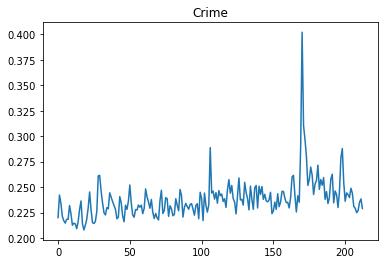

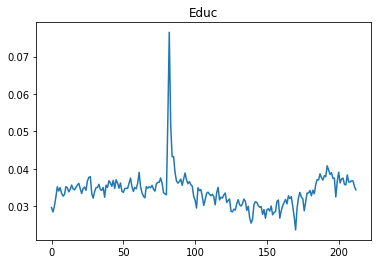

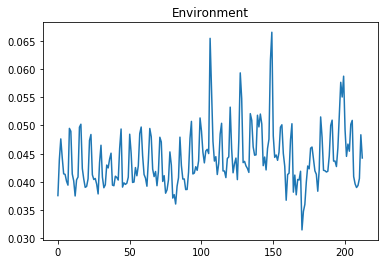

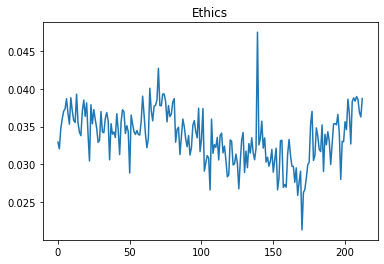

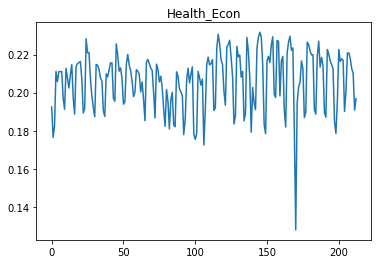

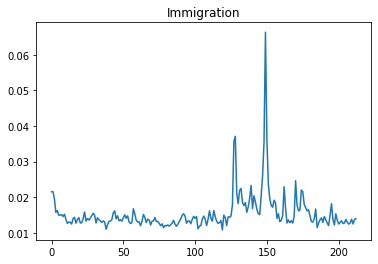

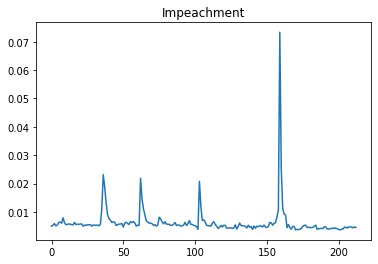

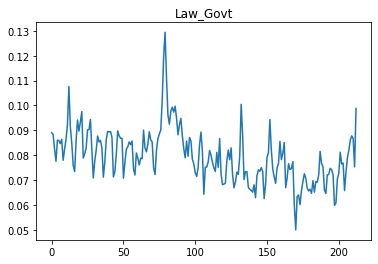

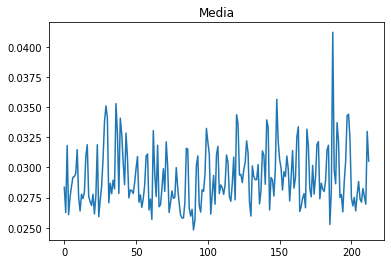

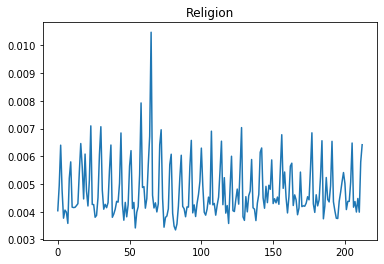

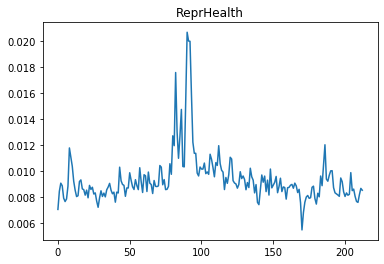

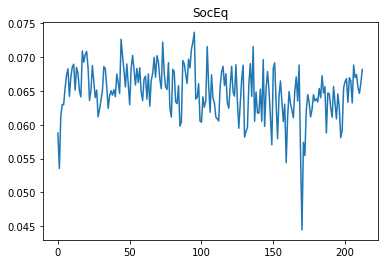

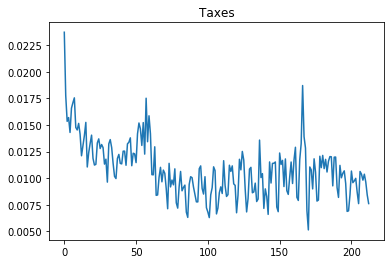

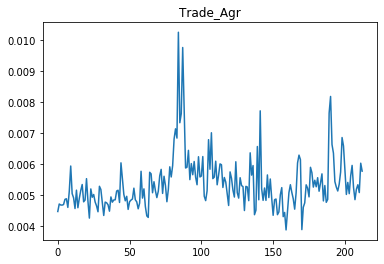

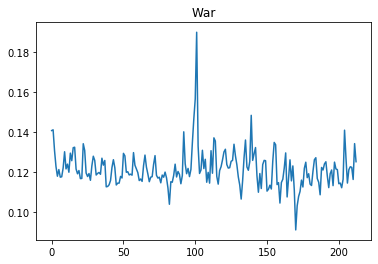

In [21]:
#Original data, no roll
reg_df_date = reg_df.drop(['Date','Hickenlooper_raw','Hickenlooper_adj' ,'Gardner_raw','Gardner_adj','Electability'], axis = 1)
reg_cols = reg_df_date.columns
for i in reg_cols: 
    plt.plot(reg_df_date[i])
    plt.title(i)
    plt.show()

# Histograms
#### Distribution of each variable

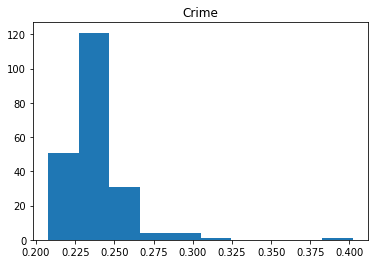

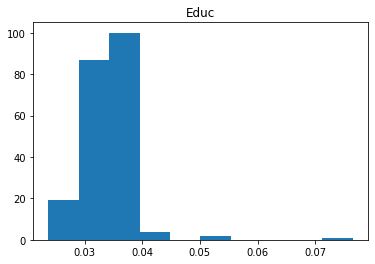

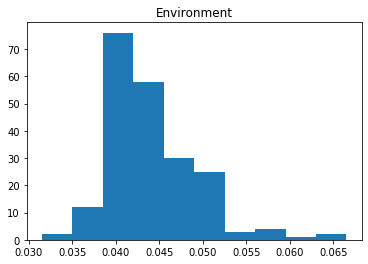

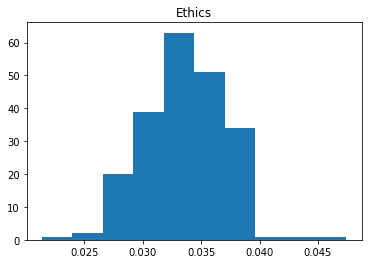

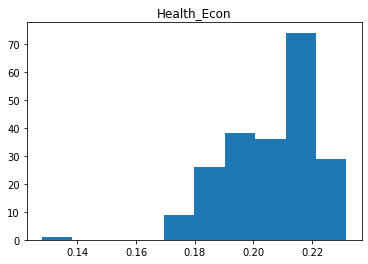

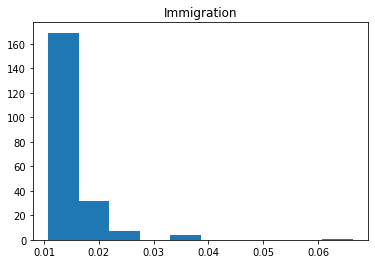

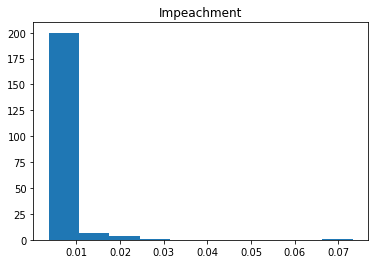

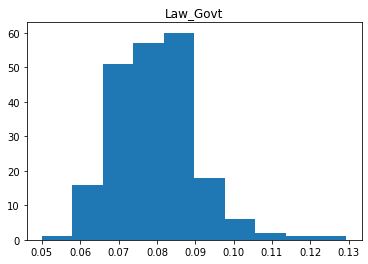

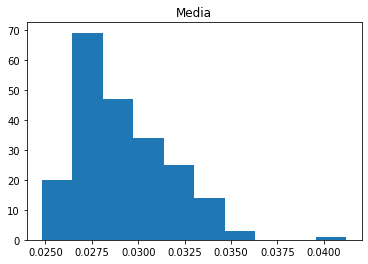

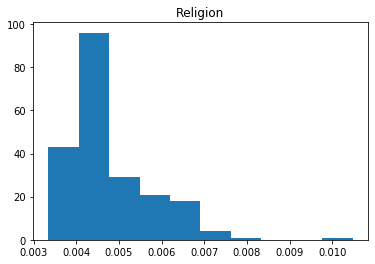

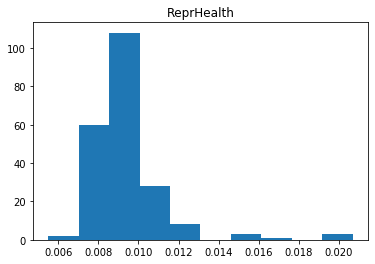

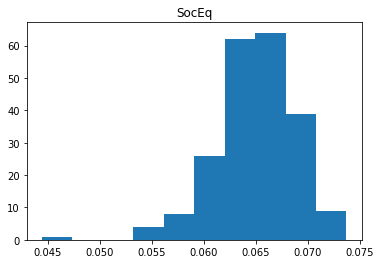

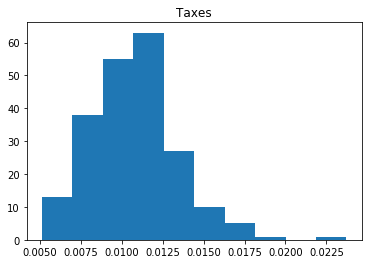

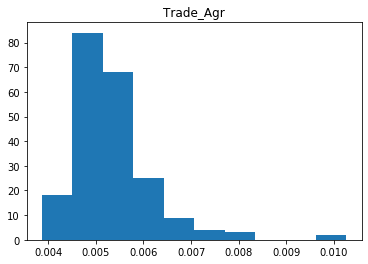

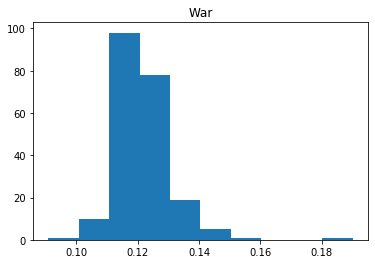

In [22]:
for i in reg_cols:
    plt.hist(reg_df_date[i])
    plt.title(i)
    plt.show()

# Rolling data
#### Use if you want to take a rolling average of the data

### rolling number give you a more steady average in term of weekly 

In [23]:
roll_7 = reg_df.set_index(['Date'])
roll_7 = roll_7.rolling(7).mean()
roll_7 = roll_7.dropna()
roll_7 = roll_7.reset_index()
roll_7.head()

,Date,Crime,Educ,Electability,Environment,Ethics,Health_Econ,Immigration,Impeachment,Law_Govt,...,Religion,ReprHealth,SocEq,Taxes,Trade_Agr,War,Hickenlooper_raw,Gardner_raw,Hickenlooper_adj,Gardner_adj
0,2019-02-21,0.223868,0.032148,0.061423,0.042341,0.035546,0.198621,0.017779,0.005609,0.084907,...,0.004566,0.008146,0.061748,0.017215,0.004708,0.127361,0.431458,0.568542,0.474020,0.525980
1,2019-02-22,0.223626,0.032694,0.060780,0.042605,0.036089,0.201267,0.016865,0.005752,0.084539,...,0.004501,0.008403,0.063106,0.016333,0.004727,0.124049,0.431255,0.568745,0.473949,0.526051
2,2019-02-23,0.222148,0.033299,0.060136,0.043396,0.036554,0.204206,0.015863,0.006134,0.083057,...,0.004539,0.008879,0.064628,0.015904,0.004786,0.121319,0.431139,0.568861,0.473909,0.526091
3,2019-02-24,0.220704,0.033739,0.059124,0.043589,0.037137,0.205449,0.015249,0.006181,0.083034,...,0.004452,0.009164,0.065462,0.015788,0.004966,0.121244,0.431176,0.568824,0.473922,0.526078
4,2019-02-25,0.219461,0.034147,0.057631,0.043172,0.037287,0.205694,0.014971,0.006240,0.084300,...,0.004367,0.009378,0.066253,0.015710,0.005019,0.121068,0.431262,0.568738,0.473952,0.526048


## Line plots for each variable after rolling data 
## Identify spikes and unusual behavior after rolling data 

In [24]:
roll_plot = roll_7.drop(['Date','Hickenlooper_raw','Hickenlooper_adj' ,'Gardner_raw','Gardner_adj','Electability'], axis = 1)
roll_plot_cols = roll_plot.columns


In [25]:
roll_plot_cols

Index(['Crime', 'Educ', 'Environment', 'Ethics', 'Health_Econ', 'Immigration',
       'Impeachment', 'Law_Govt', 'Media', 'Religion', 'ReprHealth', 'SocEq',
       'Taxes', 'Trade_Agr', 'War'],
      dtype='object')

# Rolling Train/Test and data exploration
#### Replace X variables dataframe with non rolled version if necessary

In [26]:
# if not rolling data, rename this variable and replace throughout 
# x = reg_df.drop(...)
x_7 = roll_7.drop(columns={'Date','Hickenlooper_raw','Hickenlooper_adj' ,'Gardner_raw','Gardner_adj','Electability'})

Hickenlooper_adj = roll_7['Hickenlooper_adj']
Gardner_adj = roll_7['Gardner_adj']



x_train_Hickenlooper_adj, x_test_Hickenlooper_adj, y_train_Hickenlooper_adj, y_test_Hickenlooper_adj = train_test_split(x_7, Hickenlooper_adj, test_size=0.3, random_state=42)
x_train_Gardner_adj, x_test_Gardner_adj, y_train_Gardner_adj, y_test_Gardner_adj = train_test_split(x_7, Gardner_adj, test_size=0.3, random_state=42)

### Train Test random split

In [27]:
#Hickenlooper_adj
reg_Hickenlooper_adj = LinearRegression().fit(x_train_Hickenlooper_adj, y_train_Hickenlooper_adj)
pred_train_Hickenlooper_adj = reg_Hickenlooper_adj.predict(x_train_Hickenlooper_adj)
pred_test_Hickenlooper_adj = reg_Hickenlooper_adj.predict(x_test_Hickenlooper_adj)
print('Hickenlooper_adj:: Train:', round(r2_score(y_train_Hickenlooper_adj,pred_train_Hickenlooper_adj),3),' Test:', round(r2_score(y_test_Hickenlooper_adj,pred_test_Hickenlooper_adj),3))

#Gardner_adj
reg_Gardner_adj = LinearRegression().fit(x_train_Gardner_adj, y_train_Gardner_adj)
pred_train_Gardner_adj = reg_Gardner_adj.predict(x_train_Gardner_adj)
pred_test_Gardner_adj = reg_Gardner_adj.predict(x_test_Gardner_adj)
print('Gardner_adj:: Train:', round(r2_score(y_train_Gardner_adj,pred_train_Gardner_adj),3),' Test:', round(r2_score(y_test_Gardner_adj,pred_test_Gardner_adj),3))



Hickenlooper_adj:: Train: 0.715  Test: 0.607
Gardner_adj:: Train: 0.715  Test: 0.607


### Train Test chronological split

In [28]:
Hickenlooper_adj_train = roll_7['Hickenlooper_adj'][:200]
Gardner_adj_train = roll_7['Gardner_adj'][:200]

Hickenlooper_adj_test = roll_7['Hickenlooper_adj'][200:]
Gardner_adj_test = roll_7['Gardner_adj'][200:]

x_7_train = x_7[:200]
x_7_test = x_7[200:]

In [29]:
x_7_test.describe()

,Crime,Educ,Environment,Ethics,Health_Econ,Immigration,Impeachment,Law_Govt,Media,Religion,ReprHealth,SocEq,Taxes,Trade_Agr,War
count,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
mean,0.235774,0.036755,0.044008,0.037419,0.211206,0.013022,0.004421,0.079161,0.027847,0.004719,0.008390,0.066265,0.009558,0.005350,0.122072
std,0.003763,0.000244,0.001771,0.000579,0.000913,0.000085,0.000186,0.003432,0.000509,0.000048,0.000145,0.000288,0.000039,0.000047,0.001328
min,0.230578,0.036401,0.041741,0.036479,0.209942,0.012943,0.004103,0.075093,0.027403,0.004649,0.008203,0.066008,0.009508,0.005305,0.119859
25%,0.233480,0.036632,0.042824,0.037176,0.210461,0.012965,0.004315,0.076765,0.027533,0.004695,0.008292,0.066100,0.009544,0.005321,0.121450
50%,0.234896,0.036782,0.043645,0.037488,0.211380,0.012989,0.004501,0.078733,0.027622,0.004704,0.008380,0.066159,0.009546,0.005329,0.122261
75%,0.238533,0.036828,0.045087,0.037768,0.212013,0.013066,0.004566,0.080813,0.028075,0.004748,0.008505,0.066334,0.009565,0.005369,0.122995
max,0.240916,0.037185,0.046851,0.038080,0.212170,0.013158,0.004578,0.085145,0.028691,0.004795,0.008553,0.066818,0.009632,0.005438,0.123496


In [30]:
#Hickenlooper_adj
reg_Hickenlooper_adj = LinearRegression().fit(x_7_train, Hickenlooper_adj_train)
pred_train_Hickenlooper_adj = reg_Hickenlooper_adj.predict(x_7_train)
pred_test_Hickenlooper_adj = reg_Hickenlooper_adj.predict(x_7_test)

print('Hickenlooper_adj:: Train:', round(r2_score(Hickenlooper_adj_train,pred_train_Hickenlooper_adj),3),' Test:', round(r2_score(Hickenlooper_adj_test,pred_test_Hickenlooper_adj),3))

#Gardner_adj
reg_Gardner_adj = LinearRegression().fit(x_7_train, Gardner_adj_train)
pred_train_Gardner_adj = reg_Gardner_adj.predict(x_7_train)
pred_test_Gardner_adj = reg_Gardner_adj.predict(x_7_test)
print('Gardner_adj:: Train:', round(r2_score(Gardner_adj_train,pred_train_Gardner_adj),3),' Test:', round(r2_score(Gardner_adj_test,pred_test_Gardner_adj),3))



Hickenlooper_adj:: Train: 0.707  Test: -511.435
Gardner_adj:: Train: 0.707  Test: -511.435


In [31]:
reg_Gardner_adj.score(x_7_test, Hickenlooper_adj_test)

-8634.12109889138

## PCA after Rolling data 

In [32]:
x_7.describe()

,Crime,Educ,Environment,Ethics,Health_Econ,Immigration,Impeachment,Law_Govt,Media,Religion,ReprHealth,SocEq,Taxes,Trade_Agr,War
count,207.000000,207.000000,207.000000,207.000000,207.000000,207.000000,207.000000,207.000000,207.000000,207.000000,207.000000,207.000000,207.000000,207.000000,207.000000
mean,0.238186,0.034178,0.044178,0.033639,0.206355,0.015314,0.006291,0.079471,0.029221,0.004751,0.009432,0.064951,0.010722,0.005367,0.121236
std,0.013662,0.003635,0.002969,0.002663,0.005769,0.003783,0.003065,0.008385,0.001048,0.000282,0.001583,0.002191,0.001852,0.000615,0.005223
min,0.216815,0.028536,0.037530,0.026464,0.191311,0.011992,0.003987,0.061875,0.027162,0.004256,0.007377,0.057564,0.008056,0.004525,0.107258
25%,0.230190,0.031671,0.042293,0.031634,0.203668,0.013348,0.004694,0.073849,0.028548,0.004584,0.008565,0.063532,0.009348,0.004959,0.118696
50%,0.234984,0.034698,0.043563,0.034066,0.207663,0.013901,0.005476,0.078733,0.029120,0.004718,0.009044,0.064949,0.010088,0.005300,0.120483
75%,0.242966,0.035784,0.045790,0.035351,0.210318,0.015500,0.006141,0.083713,0.029931,0.004852,0.009663,0.066480,0.012060,0.005596,0.122819
max,0.298433,0.049086,0.051931,0.039095,0.217289,0.032546,0.021019,0.106881,0.031702,0.005895,0.016507,0.069825,0.017215,0.008111,0.143021


In [33]:
x_7['tot'] = x_7.sum(axis=1)
for i in x_7.columns:
    x_7[i] = x_7[i] / x_7.tot
x_7.drop(columns={'tot'},inplace=True)

In [34]:
fa_rd = FactorAnalyzer(n_factors=14, rotation='varimax')
fa_rd.fit(x_7)

factors = pd.DataFrame(fa_rd.loadings_, index=list(x_7.columns)).style.applymap(color_big_red)
factors

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Crime,-0.905612,-0.00691891,-0.137554,-0.133279,-0.262168,-0.139427,-0.16103,-0.0775591,-0.0917725,0.0694988,-0.0229678,-0.000576617,-0.000998335,-0.0819729
Educ,0.41551,0.550808,0.210683,-0.299466,-0.262461,-0.157634,-0.0322983,-0.118208,-0.115222,-0.114077,0.210963,-0.054792,0.0448484,0.447778
Environment,-0.0855244,-0.25365,-0.00837022,0.101754,0.197447,-0.069449,-0.180188,0.0281676,0.906461,0.116341,0.0129977,-0.0142401,-0.00800206,-0.0178344
Ethics,0.730261,0.331444,-0.157983,-0.122769,0.0427499,-0.158086,0.0905461,0.143957,-0.0306626,-0.114925,0.0192629,0.0635253,0.486194,0.0353088
Health_Econ,-0.0144392,-0.0985783,-0.211672,0.931435,-0.0555109,-0.011483,0.153381,0.145262,0.0983301,0.0881781,-0.0755842,0.0233863,-0.0214433,-0.0330503
Immigration,-0.152627,-0.939607,-0.0599669,0.0611934,-0.091246,-0.0789952,-0.0174011,-0.000974542,0.222388,0.113486,-0.035998,-0.0423884,-0.0369146,0.0052507
Impeachment,0.0444468,0.0417833,-0.0327318,-0.00784153,-0.0235074,0.977734,0.0205824,0.145758,-0.0599062,0.0629689,-0.054979,-0.0221312,-0.0255975,-0.0190121
Law_Govt,0.811835,0.12815,0.166968,-0.27601,-0.0876806,0.111568,0.0255486,-0.0944522,-0.30159,-0.235989,0.0337759,-0.128786,-0.148508,-0.0151028
Media,-0.256059,-0.13504,-0.193494,0.0954541,0.0320068,0.0782991,0.0291876,0.00753979,0.116356,0.915978,-0.0468546,-0.0317811,-0.0217588,-0.0190599
Religion,0.0880361,-0.0135579,-0.112261,0.134679,0.0462386,0.153557,0.0381585,0.961224,0.0270682,0.00740986,-0.05418,0.0251064,0.0241402,-0.0162307


In [35]:
fa_rd.get_factor_variance()

(array([2.9358193 , 1.50545336, 1.30995284, 1.28128063, 1.15947341,
        1.15340934, 1.14869278, 1.09815223, 1.07339118, 1.06349733,
        0.43576883, 0.27350843, 0.26999489, 0.22160545]),
 array([0.19572129, 0.10036356, 0.08733019, 0.08541871, 0.07729823,
        0.07689396, 0.07657952, 0.07321015, 0.07155941, 0.07089982,
        0.02905126, 0.0182339 , 0.01799966, 0.0147737 ]),
 array([0.19572129, 0.29608484, 0.38341503, 0.46883374, 0.54613197,
        0.62302593, 0.69960544, 0.77281559, 0.844375  , 0.91527483,
        0.94432608, 0.96255998, 0.98055964, 0.99533333]))

# Regression
#### Recommend naming variables per candidate as in steyer_baseline instead of just baseline
#### Adjust first line for model without a constant(intercept)

### Repeat per candidate -- Gardner 

In [36]:
Gardner_adj_baseline = sm.add_constant(x_7)
mod = sm.OLS(Gardner_adj, Gardner_adj_baseline)
res = mod.fit()
print(res.summary())
# This is the baseline model with all variables

                            OLS Regression Results                            
Dep. Variable:            Gardner_adj   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     30.92
Date:                Fri, 22 Nov 2019   Prob (F-statistic):           9.61e-42
Time:                        17:48:56   Log-Likelihood:                 688.87
No. Observations:                 207   AIC:                            -1348.
Df Residuals:                     192   BIC:                            -1298.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.4636      0.199      2.326      

C:\Users\boai-\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning:

Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.



In [37]:
Gardner_adj_baseline = Gardner_adj_baseline.drop(['Trade_Agr'], axis = 1)

In [38]:
Gardner_adj_final_1 = Gardner_adj_baseline
mod = sm.OLS(Gardner_adj, Gardner_adj_final_1)
res = mod.fit()
res.summary()
#print(res.summary())
# This is the final model with significant variables remaining

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Gardner_adj   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     30.92
Date:                Fri, 22 Nov 2019   Prob (F-statistic):           9.61e-42
Time:                        17:48:56   Log-Likelihood:                 688.87
No. Observations:                 207   AIC:                            -1348.
Df Residuals:                     192   BIC:                            -1298.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.9670      2.129      0.454      0.650      -3.231       5.165
Crime          -0.6507      2.150     -0.303      0.762      -4.891       3.590
Educ           -2.4395      2.309     -1.056      0.292      -6.994       2.116
Environment     0.2086      2.200      0.095      0.925      -4.130       4.547
Ethics         -0.0597      2.226     -0.027      0.979      -4.450       4.331
Health_Econ    -0.9879      2.156     -0.458      0.647      -5.241       3.265
Immigration    -1.4479      2.136     -0.678      0.499      -5.662       2.766
Impeachment    -1.5508      2.075     -0.747      0.456      -5.644       2.542
Law_Govt        0.6475      2.148      0.301      0.763      -3.589       4.884
Media           1.2569      2.195      0.573      0.568      -3.072       5.586
Religion       -3.2392      3.168     -1.023      0.308      -9.487       3.008
ReprHealth     -0.2437      2.650     -0.092      0.927      -5.470       4.983
SocEq          -1.0241      2.027     -0.505      0.614      -5.022       2.974
Taxes           2.4204      2.031      1.192      0.235      -1.585       6.426
War             0.0230      2.154      0.011      0.991      -4.225       4.271
==============================================================================
Omnibus:                        7.266   Durbin-Watson:                   0.135
Prob(Omnibus):                  0.026   Jarque-Bera (JB):                7.523
Skew:                          -0.449   Prob(JB):                       0.0233
Kurtosis:                       2.743   Cond. No.                     1.43e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.43e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [39]:
Gardner_adj_baseline = Gardner_adj_baseline.drop(['War'], axis = 1)

In [40]:
Gardner_adj_final_2 = Gardner_adj_baseline
mod = sm.OLS(Gardner_adj, Gardner_adj_final_2)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Gardner_adj   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     33.47
Date:                Fri, 22 Nov 2019   Prob (F-statistic):           1.62e-42
Time:                        17:48:56   Log-Likelihood:                 688.87
No. Observations:                 207   AIC:                            -1350.
Df Residuals:                     193   BIC:                            -1303.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.9897      0.141      7.044      0.000       0.713       1.267
Crime          -0.6736      0.156     -4.324      0.000      -0.981      -0.366
Educ           -2.4639      0.296     -8.313      0.000      -3.049      -1.879
Environment     0.1855      0.405      0.458      0.648      -0.614       0.985
Ethics         -0.0829      0.479     -0.173      0.863      -1.027       0.861
Health_Econ    -1.0109      0.182     -5.545      0.000      -1.370      -0.651
Immigration    -1.4706      0.238     -6.173      0.000      -1.940      -1.001
Impeachment    -1.5728      0.261     -6.027      0.000      -2.087      -1.058
Law_Govt        0.6247      0.223      2.795      0.006       0.184       1.065
Media           1.2349      0.757      1.631      0.105      -0.259       2.729
Religion       -3.2601      2.487     -1.311      0.191      -8.165       1.645
ReprHealth     -0.2710      0.704     -0.385      0.701      -1.660       1.118
SocEq          -1.0449      0.570     -1.833      0.068      -2.169       0.080
Taxes           2.3992      0.445      5.391      0.000       1.521       3.277
==============================================================================
Omnibus:                        7.264   Durbin-Watson:                   0.135
Prob(Omnibus):                  0.026   Jarque-Bera (JB):                7.519
Skew:                          -0.449   Prob(JB):                       0.0233
Kurtosis:                       2.742   Cond. No.                     4.27e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.27e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [41]:
Gardner_adj_baseline = Gardner_adj_baseline.drop(['Ethics'], axis = 1)

In [42]:
Gardner_adj_final_3 = Gardner_adj_baseline
mod = sm.OLS(Gardner_adj, Gardner_adj_final_3)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Gardner_adj   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     36.44
Date:                Fri, 22 Nov 2019   Prob (F-statistic):           2.66e-43
Time:                        17:48:56   Log-Likelihood:                 688.86
No. Observations:                 207   AIC:                            -1352.
Df Residuals:                     194   BIC:                            -1308.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.9801      0.129      7.606      0.000       0.726       1.234
Crime          -0.6617      0.139     -4.747      0.000      -0.937      -0.387
Educ           -2.4819      0.277     -8.961      0.000      -3.028      -1.936
Environment     0.1972      0.399      0.495      0.621      -0.589       0.983
Health_Econ    -0.9962      0.161     -6.193      0.000      -1.313      -0.679
Immigration    -1.4641      0.235     -6.239      0.000      -1.927      -1.001
Impeachment    -1.5601      0.250     -6.245      0.000      -2.053      -1.067
Law_Govt        0.6328      0.218      2.904      0.004       0.203       1.063
Media           1.2588      0.743      1.695      0.092      -0.206       2.724
Religion       -3.3224      2.455     -1.353      0.177      -8.164       1.519
ReprHealth     -0.1946      0.548     -0.355      0.723      -1.275       0.886
SocEq          -1.0763      0.539     -1.997      0.047      -2.140      -0.013
Taxes           2.4149      0.435      5.556      0.000       1.558       3.272
==============================================================================
Omnibus:                        7.072   Durbin-Watson:                   0.135
Prob(Omnibus):                  0.029   Jarque-Bera (JB):                7.316
Skew:                          -0.443   Prob(JB):                       0.0258
Kurtosis:                       2.749   Cond. No.                     4.23e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.23e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [43]:
Gardner_adj_baseline = Gardner_adj_baseline.drop(['ReprHealth'], axis = 1)

In [44]:
Gardner_adj_final_4 = Gardner_adj_baseline
mod = sm.OLS(Gardner_adj, Gardner_adj_final_4)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Gardner_adj   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     39.92
Date:                Fri, 22 Nov 2019   Prob (F-statistic):           4.36e-44
Time:                        17:48:56   Log-Likelihood:                 688.79
No. Observations:                 207   AIC:                            -1354.
Df Residuals:                     195   BIC:                            -1314.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.9695      0.125      7.752      0.000       0.723       1.216
Crime          -0.6537      0.137     -4.763      0.000      -0.924      -0.383
Educ           -2.4966      0.273     -9.136      0.000      -3.035      -1.958
Environment     0.2137      0.395      0.541      0.589      -0.565       0.993
Health_Econ    -0.9772      0.151     -6.453      0.000      -1.276      -0.679
Immigration    -1.4772      0.231     -6.388      0.000      -1.933      -1.021
Impeachment    -1.5695      0.248     -6.333      0.000      -2.058      -1.081
Law_Govt        0.6439      0.215      2.992      0.003       0.219       1.068
Media           1.3281      0.715      1.857      0.065      -0.082       2.738
Religion       -3.0828      2.355     -1.309      0.192      -7.727       1.562
SocEq          -1.1191      0.524     -2.135      0.034      -2.153      -0.085
Taxes           2.4806      0.392      6.322      0.000       1.707       3.255
==============================================================================
Omnibus:                        6.910   Durbin-Watson:                   0.136
Prob(Omnibus):                  0.032   Jarque-Bera (JB):                7.122
Skew:                          -0.435   Prob(JB):                       0.0284
Kurtosis:                       2.735   Cond. No.                     4.05e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.05e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [45]:
Gardner_adj_baseline = Gardner_adj_baseline.drop(['Environment'], axis = 1)

In [46]:
Gardner_adj_final_5 = Gardner_adj_baseline
mod = sm.OLS(Gardner_adj, Gardner_adj_final_5)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Gardner_adj   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.676
Method:                 Least Squares   F-statistic:                     44.05
Date:                Fri, 22 Nov 2019   Prob (F-statistic):           7.37e-45
Time:                        17:48:57   Log-Likelihood:                 688.63
No. Observations:                 207   AIC:                            -1355.
Df Residuals:                     196   BIC:                            -1319.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.0180      0.087     11.692      0.000       0.846       1.190
Crime          -0.7089      0.092     -7.740      0.000      -0.889      -0.528
Educ           -2.4999      0.273     -9.168      0.000      -3.038      -1.962
Health_Econ    -1.0044      0.143     -7.042      0.000      -1.286      -0.723
Immigration    -1.4493      0.225     -6.442      0.000      -1.893      -1.006
Impeachment    -1.5955      0.243     -6.573      0.000      -2.074      -1.117
Law_Govt        0.5594      0.148      3.786      0.000       0.268       0.851
Media           1.2729      0.707      1.802      0.073      -0.121       2.666
Religion       -3.2276      2.335     -1.382      0.169      -7.833       1.378
SocEq          -1.2054      0.499     -2.418      0.017      -2.189      -0.222
Taxes           2.3751      0.340      6.989      0.000       1.705       3.045
==============================================================================
Omnibus:                        6.769   Durbin-Watson:                   0.135
Prob(Omnibus):                  0.034   Jarque-Bera (JB):                6.836
Skew:                          -0.414   Prob(JB):                       0.0328
Kurtosis:                       2.674   Cond. No.                     4.02e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.02e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [47]:
Gardner_adj_baseline = Gardner_adj_baseline.drop(['Religion'], axis = 1)

In [48]:
Gardner_adj_final_6 = Gardner_adj_baseline
mod = sm.OLS(Gardner_adj, Gardner_adj_final_6)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Gardner_adj   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     48.50
Date:                Fri, 22 Nov 2019   Prob (F-statistic):           2.61e-45
Time:                        17:48:57   Log-Likelihood:                 687.63
No. Observations:                 207   AIC:                            -1355.
Df Residuals:                     197   BIC:                            -1322.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.0078      0.087     11.590      0.000       0.836       1.179
Crime          -0.7002      0.092     -7.646      0.000      -0.881      -0.520
Educ           -2.4870      0.273     -9.104      0.000      -3.026      -1.948
Health_Econ    -1.0215      0.142     -7.173      0.000      -1.302      -0.741
Immigration    -1.4555      0.225     -6.455      0.000      -1.900      -1.011
Impeachment    -1.7029      0.230     -7.390      0.000      -2.157      -1.248
Law_Govt        0.5991      0.145      4.124      0.000       0.313       0.886
Media           1.3265      0.707      1.876      0.062      -0.068       2.721
SocEq          -1.3463      0.489     -2.752      0.006      -2.311      -0.382
Taxes           2.3827      0.341      6.996      0.000       1.711       3.054
==============================================================================
Omnibus:                        7.981   Durbin-Watson:                   0.140
Prob(Omnibus):                  0.018   Jarque-Bera (JB):                7.360
Skew:                          -0.400   Prob(JB):                       0.0252
Kurtosis:                       2.538   Cond. No.                     1.26e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.26e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [49]:
# Correlation Matrix of significant variables
Gardner_adj_final_6.drop(['const'], axis = 1).corr()

,Crime,Educ,Health_Econ,Immigration,Impeachment,Law_Govt,Media,SocEq,Taxes
Crime,1.000000,-0.303581,-0.100516,0.169885,-0.167590,-0.701185,0.277600,-0.755610,-0.316297
Educ,-0.303581,1.000000,-0.444209,-0.618166,-0.149386,0.603544,-0.408305,0.336155,-0.013599
Health_Econ,-0.100516,-0.444209,1.000000,0.201631,0.013527,-0.375951,0.245803,0.087788,0.307495
Immigration,0.169885,-0.618166,0.201631,1.000000,-0.122717,-0.357006,0.307303,-0.356993,-0.087303
Impeachment,-0.167590,-0.149386,0.013527,-0.122717,1.000000,0.143994,0.120930,-0.093276,0.069320
Law_Govt,-0.701185,0.603544,-0.375951,-0.357006,0.143994,1.000000,-0.523210,0.559569,0.164295
Media,0.277600,-0.408305,0.245803,0.307303,0.120930,-0.523210,1.000000,-0.425031,0.022220
SocEq,-0.755610,0.336155,0.087788,-0.356993,-0.093276,0.559569,-0.425031,1.000000,0.320388
Taxes,-0.316297,-0.013599,0.307495,-0.087303,0.069320,0.164295,0.022220,0.320388,1.000000


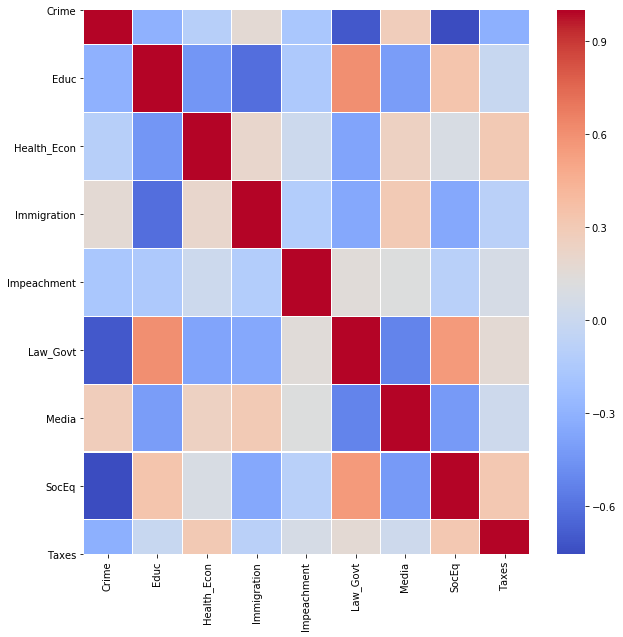

In [50]:
corrmat = Gardner_adj_final_6.drop(['const'], axis = 1).corr()
  
f, ax = plt.subplots(figsize =(10, 10)) 
sns.heatmap(corrmat, ax = ax, cmap ="coolwarm", linewidths = 0.1)

In [51]:
# Variance Inflation Factor of significant variables
pd.Series([variance_inflation_factor(Gardner_adj_final_6.values, i) 
               for i in range(Gardner_adj_final_6.shape[1])], 
              index=Gardner_adj_final_6.columns).sort_values()

Taxes              1.294859
Impeachment        1.571237
Media              1.674454
Health_Econ        1.956194
Immigration        2.278466
Educ               3.057946
SocEq              3.686067
Law_Govt           4.704103
Crime              5.029759
const          19537.530448
dtype: float64

In [52]:
Gardner_adj_final_6.describe()

,const,Crime,Educ,Health_Econ,Immigration,Impeachment,Law_Govt,Media,SocEq,Taxes
count,207.0,207.000000,207.000000,207.000000,207.000000,207.000000,207.000000,207.000000,207.000000,207.000000
mean,1.0,0.263692,0.037835,0.228443,0.016953,0.006965,0.087984,0.032349,0.071906,0.011875
std,0.0,0.015272,0.003992,0.006125,0.004175,0.003392,0.009312,0.001141,0.002448,0.002084
min,1.0,0.241348,0.031589,0.211200,0.013241,0.004385,0.069377,0.029964,0.064544,0.008922
25%,1.0,0.255208,0.035110,0.225538,0.014795,0.005205,0.081315,0.031703,0.070421,0.010344
50%,1.0,0.259791,0.038509,0.229945,0.015406,0.006076,0.086948,0.032266,0.071792,0.011111
75%,1.0,0.268668,0.039697,0.232380,0.017099,0.006825,0.092866,0.033081,0.073681,0.013379
max,1.0,0.334618,0.054197,0.240291,0.035865,0.023241,0.117952,0.035162,0.077384,0.019282


## time split testing data and training data R2

In [53]:
x_7.head()

,Crime,Educ,Environment,Ethics,Health_Econ,Immigration,Impeachment,Law_Govt,Media,Religion,ReprHealth,SocEq,Taxes,Trade_Agr,War
0,0.250748,0.036008,0.047425,0.039814,0.222469,0.019914,0.006282,0.095102,0.031629,0.005115,0.009124,0.069162,0.019282,0.005274,0.142653
1,0.250443,0.036615,0.047714,0.040417,0.225403,0.018888,0.006442,0.094677,0.031766,0.005041,0.009410,0.070674,0.018292,0.005294,0.138924
2,0.248615,0.037267,0.048566,0.040909,0.228535,0.017753,0.006864,0.092952,0.032266,0.005079,0.009937,0.072328,0.017799,0.005357,0.135773
3,0.246613,0.037700,0.048706,0.041497,0.229568,0.017039,0.006907,0.092782,0.032159,0.004975,0.010240,0.073146,0.017642,0.005549,0.135477
4,0.244920,0.038108,0.048181,0.041613,0.229556,0.016708,0.006964,0.094079,0.032347,0.004873,0.010465,0.073939,0.017533,0.005602,0.135113


In [54]:
Gardner_adj_final_6.describe()

,const,Crime,Educ,Health_Econ,Immigration,Impeachment,Law_Govt,Media,SocEq,Taxes
count,207.0,207.000000,207.000000,207.000000,207.000000,207.000000,207.000000,207.000000,207.000000,207.000000
mean,1.0,0.263692,0.037835,0.228443,0.016953,0.006965,0.087984,0.032349,0.071906,0.011875
std,0.0,0.015272,0.003992,0.006125,0.004175,0.003392,0.009312,0.001141,0.002448,0.002084
min,1.0,0.241348,0.031589,0.211200,0.013241,0.004385,0.069377,0.029964,0.064544,0.008922
25%,1.0,0.255208,0.035110,0.225538,0.014795,0.005205,0.081315,0.031703,0.070421,0.010344
50%,1.0,0.259791,0.038509,0.229945,0.015406,0.006076,0.086948,0.032266,0.071792,0.011111
75%,1.0,0.268668,0.039697,0.232380,0.017099,0.006825,0.092866,0.033081,0.073681,0.013379
max,1.0,0.334618,0.054197,0.240291,0.035865,0.023241,0.117952,0.035162,0.077384,0.019282


In [55]:
x_train_Gardner_adj_final_6, x_test_Gardner_adj_final_6, y_train_Gardner_adj_final_6, y_test_Gardner_adj_final_6 = train_test_split(x_7, Gardner_adj_final_6, test_size=0.3, random_state=42)

In [56]:
x_test_Gardner_adj_final_6.describe()

,Crime,Educ,Environment,Ethics,Health_Econ,Immigration,Impeachment,Law_Govt,Media,Religion,ReprHealth,SocEq,Taxes,Trade_Agr,War
count,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000
mean,0.265612,0.037459,0.048915,0.037219,0.227688,0.016993,0.006962,0.087260,0.032378,0.005280,0.010265,0.071713,0.011522,0.005961,0.134772
std,0.018219,0.003605,0.003526,0.003434,0.006270,0.004385,0.003722,0.009253,0.001082,0.000306,0.001500,0.002707,0.001825,0.000695,0.007277
min,0.241348,0.031691,0.042111,0.029724,0.213895,0.013360,0.004412,0.071054,0.030240,0.004835,0.008296,0.065109,0.008922,0.005014,0.121453
25%,0.255733,0.034109,0.046889,0.034521,0.224119,0.014795,0.005098,0.081222,0.031897,0.005082,0.009434,0.069853,0.010283,0.005522,0.131188
50%,0.261145,0.038507,0.048018,0.037470,0.229416,0.015290,0.006016,0.086517,0.032301,0.005235,0.010062,0.071617,0.011005,0.005881,0.133752
75%,0.268773,0.039462,0.050951,0.039402,0.231678,0.017064,0.006900,0.091727,0.033035,0.005413,0.010487,0.073406,0.012781,0.006194,0.136109
max,0.329984,0.051522,0.057136,0.043408,0.238787,0.035504,0.022685,0.116185,0.034457,0.006483,0.017624,0.076317,0.017473,0.008950,0.158134


In [57]:
#Gardner_adj_final_6
reg_Gardner_adj_final_6 = LinearRegression().fit(x_train_Gardner_adj_final_6, y_train_Gardner_adj_final_6)
post_train_Gardner_adj_final_6 = reg_Gardner_adj_final_6.predict(x_train_Gardner_adj_final_6)
post_test_Gardner_adj_final_6 = reg_Gardner_adj_final_6.predict(x_test_Gardner_adj_final_6)
print('Gardner_adj_final_6:: Train:', round(r2_score(y_train_Gardner_adj_final_6,post_train_Gardner_adj_final_6),3),' Test:', round(r2_score(y_test_Gardner_adj_final_6,post_test_Gardner_adj_final_6),3))



Gardner_adj_final_6:: Train: 1.0  Test: 1.0


# ===================================

# ===================================

# Candidate Term Attribution Models
#### Models using only the terms that the candidates have used

In [58]:
#Read in attribution file
attribution = pd.read_excel(r'C:\Users\boai-\Desktop\UnumAI\Colorado analysis\2020 CO Attribution.xlsx')
attribution.head()

,Unnamed: 0,Cory Gardner,John Hickenlooper,Other Dems
0,farmers market,0,0,1
1,colorado land,1,0,0
2,land,20,5,9
3,lands,28,8,24
4,lands day,1,0,1


In [59]:
attribution['Term'] = attribution['Unnamed: 0']

In [60]:
#join with original data
att_data = data.merge(attribution, on = 'Term', how = 'inner')
att_data = att_data.fillna(0)
att_data.shape
#att_data.head()

(7799, 250)

In [61]:
att_data.head()

,Unnamed: 0_x,Term,Category,2019-02-15 00:00:00,2019-02-16 00:00:00,2019-02-17 00:00:00,2019-02-18 00:00:00,2019-02-19 00:00:00,2019-02-20 00:00:00,2019-02-21 00:00:00,...,2019-10-10 00:00:00,2019-10-11 00:00:00,2019-10-12 00:00:00,2019-10-13 00:00:00,2019-10-14 00:00:00,2019-10-15 00:00:00,Unnamed: 0_y,Cory Gardner,John Hickenlooper,Other Dems
0,0,% of people,Electability,0.000000,0.000016,0.000000,0.000000,0.000010,0.000000,0.000000,...,0.000000,0.000012,0.000000,0.000000,0.000000,0.000000,% of people,0,1,0
1,1,1 diabetes,Healthcare,0.000014,0.000016,0.000019,0.000000,0.000000,0.000000,0.000011,...,0.000011,0.000021,0.000015,0.000018,0.000012,0.000010,1 diabetes,0,0,1
2,2,1 president,Electability,0.000031,0.000035,0.000075,0.000071,0.000041,0.000077,0.000029,...,0.000047,0.000055,0.000030,0.000040,0.000041,0.000028,1 president,0,0,1
3,3,10 women,Social Equality,0.000010,0.000000,0.000019,0.000012,0.000000,0.000011,0.000011,...,0.000011,0.000021,0.000000,0.000000,0.000012,0.000018,10 women,0,0,1
4,4,100 homes,Economy,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100 homes,0,0,1


In [62]:
Hickenlooper_att = att_data[att_data['John Hickenlooper'] > 0]
Hickenlooper_att = Hickenlooper_att.drop(['Unnamed: 0_x','Unnamed: 0_y','Cory Gardner','Other Dems'],axis = 1)

In [63]:
Hickenlooper_att.head()

,Term,Category,2019-02-15 00:00:00,2019-02-16 00:00:00,2019-02-17 00:00:00,2019-02-18 00:00:00,2019-02-19 00:00:00,2019-02-20 00:00:00,2019-02-21 00:00:00,2019-02-22 00:00:00,...,2019-10-07 00:00:00,2019-10-08 00:00:00,2019-10-09 00:00:00,2019-10-10 00:00:00,2019-10-11 00:00:00,2019-10-12 00:00:00,2019-10-13 00:00:00,2019-10-14 00:00:00,2019-10-15 00:00:00,John Hickenlooper
0,% of people,Electability,0.000000,0.000016,0.000000,0.000000,0.000010,0.000000,0.000000,0.000000,...,0.000000,0.000011,0.000000,0.000000,0.000012,0.000000,0.000000,0.000000,0.000000,1
9,12 people,Public Safety,0.000007,0.000000,0.000034,0.000009,0.000007,0.000000,0.000008,0.000000,...,0.000009,0.000000,0.000008,0.000000,0.000000,0.000033,0.000000,0.000000,0.000007,2
23,2020 dem,Electability,0.000000,0.000000,0.000000,0.000000,0.000018,0.000011,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000013,0.000000,0.000000,0.000000,0.000009,1
24,2020 democrats,Electability,0.000019,0.000035,0.000051,0.000034,0.000078,0.000081,0.000034,0.000024,...,0.000018,0.000020,0.000018,0.000041,0.000029,0.000027,0.000000,0.000011,0.000012,1
25,2020 election,Electability,0.000035,0.000015,0.000030,0.000015,0.000060,0.000036,0.000026,0.000024,...,0.000044,0.000049,0.000028,0.000047,0.000059,0.000060,0.000035,0.000050,0.000043,2


In [64]:
H_group = Hickenlooper_att[['Category', 'Term']].groupby('Category').count()
H_group.head()

,Term
Category,
Agriculture,24
Campaign Finance,19
Congress,70
Conspiracy,10
Corporate Regulation,20


In [65]:
H_group.shape

(33, 1)

In [66]:
Gardner_att = att_data[att_data['Cory Gardner'] > 0]
Gardner_att = Gardner_att.drop(['Unnamed: 0_x','Unnamed: 0_y','John Hickenlooper','Other Dems'],axis = 1)

In [67]:
Gardner_att.head()

,Term,Category,2019-02-15 00:00:00,2019-02-16 00:00:00,2019-02-17 00:00:00,2019-02-18 00:00:00,2019-02-19 00:00:00,2019-02-20 00:00:00,2019-02-21 00:00:00,2019-02-22 00:00:00,...,2019-10-07 00:00:00,2019-10-08 00:00:00,2019-10-09 00:00:00,2019-10-10 00:00:00,2019-10-11 00:00:00,2019-10-12 00:00:00,2019-10-13 00:00:00,2019-10-14 00:00:00,2019-10-15 00:00:00,Cory Gardner
5,100+ northern colorado veterans,Veterans,0.000433,0.000409,0.000438,0.000425,0.000552,0.000539,0.000568,0.000577,...,0.000457,0.000520,0.000418,0.000606,0.000446,0.000563,0.000508,0.000471,0.000600,1
7,115th congress,Congress,0.000008,0.000031,0.000011,0.000010,0.000023,0.000009,0.000000,0.000000,...,0.000009,0.000000,0.000008,0.000000,0.000009,0.000000,0.000000,0.000000,0.000016,1
8,116th congress,Congress,0.000035,0.000000,0.000000,0.000027,0.000014,0.000024,0.000023,0.000020,...,0.000034,0.000024,0.000008,0.000016,0.000009,0.000000,0.000013,0.000027,0.000022,2
13,19th amendment,Social Equality,0.000097,0.000045,0.000059,0.000098,0.000093,0.000101,0.000146,0.000148,...,0.000130,0.000139,0.000145,0.000148,0.000124,0.000070,0.000074,0.000149,0.000139,2
20,2018 farm,Agriculture,0.000000,0.000000,0.000019,0.000000,0.000010,0.000011,0.000000,0.000014,...,0.000000,0.000000,0.000010,0.000000,0.000012,0.000000,0.000000,0.000012,0.000010,1


In [68]:
G_group = Gardner_att[['Category', 'Term']].groupby('Category').count()
G_group.head()

,Term
Category,
Agriculture,27
Campaign Finance,4
Congress,84
Conspiracy,9
Corporate Regulation,15


In [69]:
G_group.shape

(33, 1)

In [70]:
result = pd.merge(H_group, G_group, how='left', on=['Category'])
result.columns = ['John Hicklooper','Cory Gardner']
result.head()

,John Hicklooper,Cory Gardner
Category,,
Agriculture,24,27
Campaign Finance,19,4
Congress,70,84
Conspiracy,10,9
Corporate Regulation,20,15


In [96]:
from openpyxl.workbook import Workbook
result.to_excel('result.xlsx')

In [71]:
#result = result.reset_index()
#result = result.rename(columns = { 'index': "Category"})
#result.head()

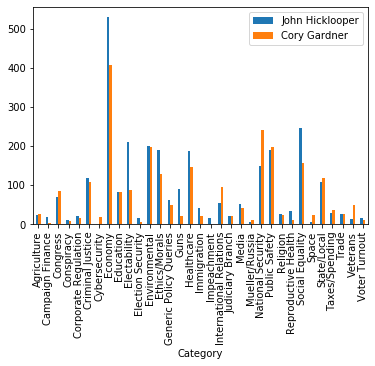

In [72]:
import pandas as pd
import matplotlib.pyplot as plt


#df3=result[['Cory Gardner','John Hicklooper']].set_index('Category')
#print(df3)
result.plot.bar()             # standard bar chart
#plt.tight_layout()
plt.show()


In [73]:
reg_df_Gardner = pd.merge(Gardner_att,pca_cats,on='Category',how='left').drop(["Term"],axis = 1).groupby('Component').sum().T


In [74]:
reg_df_Gardner.head()

Component,Crime,Educ,Electability,Environment,Ethics,Health_Econ,Immigration,Impeachment,Law_Govt,Media,Religion,ReprHealth,SocEq,Taxes,Trade_Agr,War
2019-02-15 00:00:00,0.148527,0.018584,0.035798,0.024680,0.022863,0.117276,0.007708,0.002802,0.056532,0.014520,0.001035,0.001511,0.026968,0.019855,0.003619,0.116907
2019-02-16 00:00:00,0.159774,0.017217,0.035676,0.026883,0.022847,0.104259,0.008230,0.003098,0.062722,0.013245,0.001293,0.001894,0.025467,0.014493,0.003840,0.117086
2019-02-17 00:00:00,0.154844,0.017873,0.035791,0.028992,0.024000,0.107409,0.007653,0.003374,0.055604,0.016810,0.001458,0.002137,0.027708,0.012134,0.003574,0.102856
2019-02-18 00:00:00,0.151408,0.019916,0.036435,0.027780,0.025173,0.133160,0.005971,0.003052,0.048597,0.012986,0.001164,0.001937,0.028788,0.011299,0.003724,0.094210
2019-02-19 00:00:00,0.149143,0.022344,0.039508,0.026966,0.026282,0.126898,0.006010,0.003156,0.053818,0.013572,0.000942,0.001682,0.027925,0.009954,0.003785,0.091590


In [75]:
#reg_df_Gardner = reg_df_Gardner.drop('Unnamed: 0', axis = 0)
reg_df_Gardner = reg_df_Gardner.reset_index().rename(columns={'index':'Date'})
reg_df_Gardner['Date'] = pd.to_datetime(reg_df_Gardner['Date'], infer_datetime_format=True)
reg_df_Gardner = pd.merge(reg_df_Gardner,dependents,on='Date',how='inner')
reg_df_Gardner = reg_df_Gardner.fillna(0)
reg_df_Gardner.head()

ValueError: ('Unknown string format:', 'Cory Gardner')

In [ ]:
reg_df_Gardner = reg_df_Gardner.drop(['Date','Hickenlooper_raw','Hickenlooper_adj' ,'Gardner_raw','Gardner_adj','Electability'], axis = 1)


In [ ]:
reg_df_Gardner.head()

# =======================================

# Gardner - attribution model

## regression model for term Immpeachment 

In [76]:
pca_cat = pd.read_excel('2020 Dems Category Mapping.xlsx')
dependents = pd.read_excel('2020 Dependent.xlsx')

In [77]:
data = pd.read_excel(r'C:\Users\boai-\Desktop\UnumAI\Colorado analysis\2020_CO_terms_Law_Govt_cleaned.xlsx')

In [78]:
dependents = dependents.rename(columns = {'Unnamed: 0':'Date'})

In [79]:
dependents.shape

(213, 5)

In [80]:
dependents

,Date,Hickenlooper_raw,Gardner_raw,Hickenlooper_adj,Gardner_adj
0,2019-02-15,0.431907,0.568093,0.474177,0.525823
1,2019-02-16,0.431490,0.568510,0.474032,0.525968
2,2019-02-17,0.430931,0.569069,0.473836,0.526164
3,2019-02-18,0.430737,0.569263,0.473768,0.526232
4,2019-02-19,0.432308,0.567692,0.474318,0.525682
...,...,...,...,...,...
208,2019-09-11,0.561576,0.438424,0.519562,0.480438
209,2019-09-12,0.561216,0.438784,0.519436,0.480564
210,2019-09-13,0.561136,0.438864,0.519408,0.480592
211,2019-09-14,0.561026,0.438974,0.519369,0.480631


In [81]:
data.head()

,Unnamed: 0,Term,Category,2019-02-15 00:00:00,2019-02-16 00:00:00,2019-02-17 00:00:00,2019-02-18 00:00:00,2019-02-19 00:00:00,2019-02-20 00:00:00,2019-02-21 00:00:00,...,2019-10-06 00:00:00,2019-10-07 00:00:00,2019-10-08 00:00:00,2019-10-09 00:00:00,2019-10-10 00:00:00,2019-10-11 00:00:00,2019-10-12 00:00:00,2019-10-13 00:00:00,2019-10-14 00:00:00,2019-10-15 00:00:00
0,0,115th congress,Law_Govt,0.000008,0.000031,0.000011,0.000010,0.000023,0.000009,NaN,...,NaN,0.000009,NaN,0.000008,NaN,0.000009,NaN,NaN,NaN,0.000016
1,1,116th congress,Law_Govt,0.000035,NaN,NaN,0.000027,0.000014,0.000024,0.000023,...,0.000046,0.000034,0.000024,0.000008,0.000016,0.000009,NaN,0.000013,0.000027,0.000022
2,2,2 house,Law_Govt,0.000042,0.000013,0.000018,0.000045,0.000046,0.000039,0.000029,...,0.000036,0.000079,0.000071,0.000062,0.000055,0.000058,0.000058,0.000019,0.000063,0.000052
3,3,3 branches of government,Law_Govt,0.000062,0.000031,0.000055,0.000062,0.000062,0.000052,0.000055,...,0.000065,0.000077,0.000054,0.000070,0.000086,0.000061,0.000024,0.000047,0.000044,0.000076
4,4,achieved,Law_Govt,0.000011,0.000015,0.000020,0.000011,NaN,0.000024,0.000011,...,NaN,0.000014,0.000011,0.000024,NaN,0.000013,0.000013,NaN,0.000012,NaN


In [82]:
# importing pandas as pd 
import pandas as pd 
data = data.drop('Unnamed: 0',axis =1)
data = data.drop('Category',axis =1)


In [83]:
data = data.transpose()
new_header = data.iloc[0] #grab the first row for the header
data = data[1:] #take the data less the header row
data.columns = new_header #set the header row as the df header
data = data.reset_index()
data = data.rename(columns = { 'index': "Date"})
data.head()

Term,Date,115th congress,116th congress,2 house,3 branches of government,achieved,achievements,advocate,advocates,advocating,...,sponsors,stacey abrams,subsidiary,us companies,use act,vote,vote of confidence,vote today,voted,voter
0,2019-02-15,7.59807e-06,3.49511e-05,4.24407e-05,6.24127e-05,1.09222e-05,2.73056e-05,0.000149791,4.99302e-05,1.24825e-05,...,5.46112e-06,1.31067e-05,7.82488e-06,1.04021e-05,1.17373e-05,0.000436889,NaN,3.12995e-05,0.000227182,2.91259e-05
1,2019-02-16,3.07001e-05,NaN,1.28864e-05,3.07001e-05,1.52603e-05,NaN,0.000142337,4.74455e-05,1.58152e-05,...,1.14452e-05,2.71823e-05,1.44973e-05,9.31966e-06,1.28864e-05,0.000260951,NaN,6.44322e-06,8.11846e-05,3.47934e-05
2,2019-02-17,1.12353e-05,NaN,1.75856e-05,5.51549e-05,2.02235e-05,4.44916e-05,0.000242682,4.04469e-05,2.02235e-05,...,1.96617e-05,1.44453e-05,1.41564e-05,NaN,1.41564e-05,0.000219088,8.08939e-06,NaN,5.05587e-05,5.05587e-05
3,2019-02-18,9.66475e-06,2.73834e-05,4.54449e-05,6.16128e-05,1.06e-05,1.06e-05,0.000213591,6.57203e-05,3.28601e-05,...,1.23226e-05,5.86788e-06,1.17358e-05,1.91684e-05,2.05376e-05,0.000205376,5.86788e-06,5.86788e-06,1.82556e-05,2.28195e-05
4,2019-02-19,2.29852e-05,1.42289e-05,4.56011e-05,6.18222e-05,NaN,3.3632e-05,0.000211655,3.73509e-05,1.24503e-05,...,1.06717e-05,4.1501e-06,5.10782e-06,9.05476e-06,1.66004e-05,0.000209165,NaN,5.10782e-06,6.8149e-05,5.24223e-05


In [84]:
#data[212:]
data = data.drop(data.index[213:])


In [85]:
all_df_list = [data, dependents]


In [86]:
data.shape

(213, 694)

In [87]:
dependents.shape

(213, 5)

In [88]:
reg_df = pd.merge(data,dependents,on='Date',how='left')

In [89]:
reg_df = reg_df.fillna(0)

In [90]:
reg_df.head()

,Date,115th congress,116th congress,2 house,3 branches of government,achieved,achievements,advocate,advocates,advocating,...,use act,vote,vote of confidence,vote today,voted,voter,Hickenlooper_raw,Gardner_raw,Hickenlooper_adj,Gardner_adj
0,2019-02-15,0.000008,0.000035,0.000042,0.000062,0.000011,0.000027,0.000150,0.000050,0.000012,...,0.000012,0.000437,0.000000,0.000031,0.000227,0.000029,0.431907,0.568093,0.474177,0.525823
1,2019-02-16,0.000031,0.000000,0.000013,0.000031,0.000015,0.000000,0.000142,0.000047,0.000016,...,0.000013,0.000261,0.000000,0.000006,0.000081,0.000035,0.431490,0.568510,0.474032,0.525968
2,2019-02-17,0.000011,0.000000,0.000018,0.000055,0.000020,0.000044,0.000243,0.000040,0.000020,...,0.000014,0.000219,0.000008,0.000000,0.000051,0.000051,0.430931,0.569069,0.473836,0.526164
3,2019-02-18,0.000010,0.000027,0.000045,0.000062,0.000011,0.000011,0.000214,0.000066,0.000033,...,0.000021,0.000205,0.000006,0.000006,0.000018,0.000023,0.430737,0.569263,0.473768,0.526232
4,2019-02-19,0.000023,0.000014,0.000046,0.000062,0.000000,0.000034,0.000212,0.000037,0.000012,...,0.000017,0.000209,0.000000,0.000005,0.000068,0.000052,0.432308,0.567692,0.474318,0.525682


In [91]:
# if not rolling data, rename this variable and replace throughout 
# x = reg_df.drop(...)
x_7 = reg_df.drop(columns={'Date','Hickenlooper_raw','Hickenlooper_adj' ,'Gardner_raw','Gardner_adj'}, axis = 1)

Hickenlooper_adj = reg_df['Hickenlooper_adj']
Gardner_adj = reg_df['Gardner_adj']



x_train_Hickenlooper_adj, x_test_Hickenlooper_adj, y_train_Hickenlooper_adj, y_test_Hickenlooper_adj = train_test_split(x_7, Hickenlooper_adj, test_size=0.3, random_state=42)
x_train_Gardner_adj, x_test_Gardner_adj, y_train_Gardner_adj, y_test_Gardner_adj = train_test_split(x_7, Gardner_adj, test_size=0.3, random_state=42)

In [92]:
#Hickenlooper_adj
reg_Hickenlooper_adj = LinearRegression().fit(x_train_Hickenlooper_adj, y_train_Hickenlooper_adj)
pred_train_Hickenlooper_adj = reg_Hickenlooper_adj.predict(x_train_Hickenlooper_adj)
pred_test_Hickenlooper_adj = reg_Hickenlooper_adj.predict(x_test_Hickenlooper_adj)
print('Hickenlooper_adj:: Train:', round(r2_score(y_train_Hickenlooper_adj,pred_train_Hickenlooper_adj),3),' Test:', round(r2_score(y_test_Hickenlooper_adj,pred_test_Hickenlooper_adj),3))

#Gardner_adj
reg_Gardner_adj = LinearRegression().fit(x_train_Gardner_adj, y_train_Gardner_adj)
pred_train_Gardner_adj = reg_Gardner_adj.predict(x_train_Gardner_adj)
pred_test_Gardner_adj = reg_Gardner_adj.predict(x_test_Gardner_adj)
print('Gardner_adj:: Train:', round(r2_score(y_train_Gardner_adj,pred_train_Gardner_adj),3),' Test:', round(r2_score(y_test_Gardner_adj,pred_test_Gardner_adj),3))



Hickenlooper_adj:: Train: 1.0  Test: 0.364
Gardner_adj:: Train: 1.0  Test: 0.364


In [93]:
Hickenlooper_adj_train = roll_7['Hickenlooper_adj'][:200]
Gardner_adj_train = roll_7['Gardner_adj'][:200]

Hickenlooper_adj_test = roll_7['Hickenlooper_adj'][200:]
Gardner_adj_test = roll_7['Gardner_adj'][200:]

x_7_train = x_7[:200]
x_7_test = x_7[200:]

In [94]:
x_7_test.describe()

,115th congress,116th congress,2 house,3 branches of government,achieved,achievements,advocate,advocates,advocating,affairs,...,sponsors,stacey abrams,subsidiary,us companies,use act,vote,vote of confidence,vote today,voted,voter
count,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,...,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000
mean,0.000002,0.000016,0.000045,0.000103,0.000010,0.000018,0.000195,0.000046,0.000017,0.000600,...,0.000012,0.000007,0.000006,0.000008,0.000016,0.000227,0.000006,0.000008,0.000031,0.000029
std,0.000004,0.000010,0.000015,0.000060,0.000007,0.000016,0.000046,0.000015,0.000016,0.000090,...,0.000003,0.000007,0.000004,0.000005,0.000005,0.000070,0.000003,0.000005,0.000015,0.000014
min,0.000000,0.000000,0.000019,0.000037,0.000000,0.000000,0.000140,0.000023,0.000000,0.000449,...,0.000006,0.000000,0.000000,0.000000,0.000007,0.000123,0.000000,0.000000,0.000005,0.000014
25%,0.000000,0.000015,0.000036,0.000083,0.000000,0.000011,0.000148,0.000034,0.000014,0.000569,...,0.000009,0.000000,0.000006,0.000005,0.000013,0.000182,0.000006,0.000006,0.000021,0.000019
50%,0.000000,0.000017,0.000046,0.000092,0.000011,0.000016,0.000182,0.000044,0.000016,0.000628,...,0.000012,0.000006,0.000006,0.000009,0.000015,0.000211,0.000006,0.000006,0.000028,0.000026
75%,0.000000,0.000018,0.000056,0.000124,0.000014,0.000019,0.000240,0.000056,0.000017,0.000643,...,0.000015,0.000007,0.000009,0.000011,0.000019,0.000275,0.000009,0.000010,0.000042,0.000037
max,0.000010,0.000039,0.000069,0.000268,0.000021,0.000060,0.000250,0.000066,0.000054,0.000747,...,0.000018,0.000019,0.000014,0.000018,0.000028,0.000385,0.000011,0.000016,0.000059,0.000062


In [95]:
Gardner_adj_baseline = sm.add_constant(x_7)
mod = sm.OLS(Gardner_adj, Gardner_adj_baseline)
res = mod.fit()
print(res.summary())
# This is the baseline model with all variables

C:\Users\boai-\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning:

Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.

C:\Users\boai-\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1648: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\boai-\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1649: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\boai-\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1665: RuntimeWarning:

divide by zero encountered in double_scalars

C:\Users\boai-\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1578: RuntimeWarning:

divide by zero encountered in double_scalars

C:\Users\boai-\Anaconda3\lib\site-packages\statsmodels\base\model.py:1376: RuntimeWarning:

invalid value encountered in multiply

C:\Users\boai-\AppData\Roaming\Python\Python37\site-packages\scipy\stats\_distn_infrast

                            OLS Regression Results                            
Dep. Variable:            Gardner_adj   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                     0.000
Date:                Fri, 22 Nov 2019   Prob (F-statistic):                nan
Time:                        17:49:50   Log-Likelihood:                 7047.1
No. Observations:                 213   AIC:                        -1.367e+04
Df Residuals:                       0   BIC:                        -1.295e+04
Df Model:                         212                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------